In [1]:
# Dependencies
from sodapy import Socrata
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from config import appToken, api_key
from census import Census

In [2]:
# Use open client to obtain CDC COVID-19 death rates, including age/sex data
client = Socrata("data.cdc.gov", appToken)
results = client.get("9bhg-hcku", limit=4000000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

In [3]:
# Convert state values for New York City to New York state
results_df['state'] = results_df['state'].replace(['New York City'],'New York')

# Filter DataFrame for State COVID-19 death totals only
results_states = results_df.loc[(results_df['state'] != 'United States') & (results_df['age_group'] == 'All Ages') & (results_df['group'] == 'By Total') & (results_df['sex'] == 'All Sexes')]
results_states = results_states[['state', 'covid_19_deaths']]

# Create copy of DataFrame for tabulation, convert and sort death counts descending
converted_states_df = results_states.copy()
converted_states_df = converted_states_df.astype({"covid_19_deaths": "int64"})
converted_states_df.groupby('state').agg({'covid_19_deaths': 'sum'})
converted_states_df2 = converted_states_df.groupby('state')['covid_19_deaths'].sum()

states_df = pd.DataFrame(converted_states_df2).sort_values('covid_19_deaths',ascending=False)
states_df

,covid_19_deaths
state,
California,94418
Texas,94388
New York,70606
Florida,69603
Pennsylvania,45800
Ohio,43151
Illinois,34143
Georgia,32190
New Jersey,31773


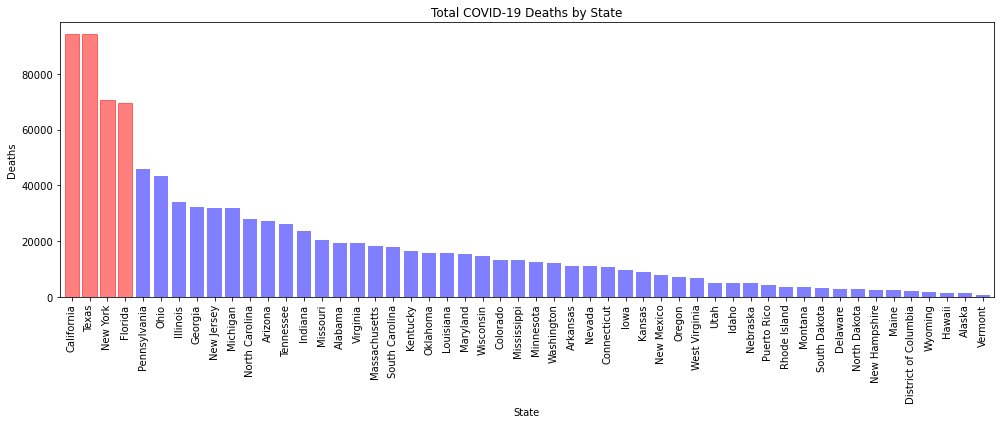

In [4]:
# Plot COVID-19 death totals by State
# Set x axis and tick locations
x_axis = np.arange(len(states_df['covid_19_deaths']))
tick_locations = [value+0.4 for value in x_axis]

states = list(states_df.index.values)
states

# Create a list indicating where to write x labels and set figure size to adjust for space
# Also assign separate color for three states with highest rates
plt.figure(figsize=(14,6))
barplot = plt.bar(x_axis, states_df['covid_19_deaths'], color='blue', alpha=0.5, align="edge")
plt.xticks(tick_locations, states, rotation="vertical")
barplot[0].set_color('red')
barplot[1].set_color('red')
barplot[2].set_color('red')
barplot[3].set_color('red')

# Set x and y limits
plt.xlim(-0.25, len(x_axis))
plt.ylim(0, max(states_df['covid_19_deaths'])+4000)

# Set Title and Labels
plt.title("Total COVID-19 Deaths by State")
plt.xlabel("State")
plt.ylabel("Deaths")

# Display the chart, and export for later use
plt.tight_layout()
plt.savefig("Images/deathct_by_state.png")
plt.show()

In [5]:
# Filter CDC data for the three states with highest COVID-19 deaths, to include
# data for both sexes, all ages
results_sex = results_df.loc[((results_df['state'] == 'New York') | (results_df['state'] == 'Texas') | (results_df['state'] == 'California') | (results_df['state'] == 'Florida')) & (results_df['age_group'] == 'All Ages') & (results_df['group'] == 'By Total') & (results_df['sex'] != 'All Sexes')]
results_sex = results_sex[['state', 'sex', 'covid_19_deaths']]
results_sex = results_sex.astype({"covid_19_deaths": "int64"})

# Create copy of DataFrame for tabulation, convert death total to integer for summation
results_sex = results_sex.groupby(['state','sex']).agg({'covid_19_deaths': 'sum'})
converted_sex_df = pd.DataFrame(results_sex)
converted_sex_df.reset_index(drop=False, inplace=True)
converted_sex_df

,state,sex,covid_19_deaths
0,California,Female,38712
1,California,Male,55706
2,Florida,Female,30156
3,Florida,Male,39447
4,New York,Female,31741
5,New York,Male,38865
6,Texas,Female,39729
7,Texas,Male,54659


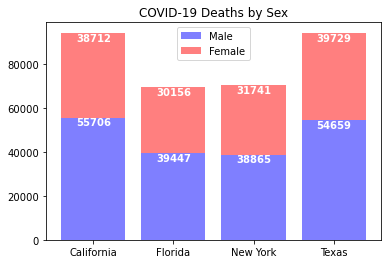

In [6]:
# Create lists for plotting
state_lst = []
male_ct = converted_sex_df[converted_sex_df["sex"] == 'Male']["covid_19_deaths"].tolist()
female_ct = converted_sex_df[converted_sex_df["sex"] == 'Female']["covid_19_deaths"].tolist()

for state in converted_sex_df['state']:
    if state in state_lst:
        pass
    else:
        state_lst.append(state)

# Plot COVID-19 death counts by State, stacking bars by Sex, assigning title/legend
plt.bar(state_lst, male_ct, color='b', label="Male", alpha=0.5)
plt.bar(state_lst, female_ct, bottom=male_ct, color='r',label="Female", alpha=0.5)
plt.title("COVID-19 Deaths by Sex")
plt.legend(loc="upper center")

# Display total counts by sex at the top of each bar
for i in range(len(state_lst)):
    plt.text(i, male_ct[i], male_ct[i], ha="center", va="top", color="w", fontweight="bold")
    plt.text(i, female_ct[i]+male_ct[i], female_ct[i], ha="center", va="top", color="w", fontweight="bold")

# Display the chart, and export for later use
plt.savefig("Images/deathct_by_sex.png")
plt.show()

In [7]:
# Filter CDC data for the three states with highest COVID-19 deaths, to include
# death data for all age groups without overlap
results_age = results_df.loc[((results_df['state'] == 'New York') | (results_df['state'] == 'Texas') | (results_df['state'] == 'California') | (results_df['state'] == 'Florida')) & (results_df['age_group'] != 'All Ages') & (results_df['group'] == 'By Total') & (results_df['sex'] == 'All Sexes')]
results_age2 = results_age.loc[(results_df['age_group'] == '0-17 years') | (results_df['age_group'] == '18-29 years') | (results_df['age_group'] == '30-39 years') | (results_df['age_group'] == '40-49 years') | (results_df['age_group'] == '50-64 years') | (results_df['age_group'] == '65-74 years') | (results_df['age_group'] == '75-84 years') | (results_df['age_group'] == '85 years and over')]
results_age2 = results_age2[['state', 'age_group', 'covid_19_deaths']]

# Create copy of DataFrame for tabulation, convert death total to integer for summation
age_df = results_age2.copy()
age_df = results_age2.astype({"covid_19_deaths": "int64"})
age_df = age_df.groupby(['state','age_group']).agg({'covid_19_deaths': 'sum'})
converted_age_df = pd.DataFrame(age_df)
converted_age_df.reset_index(drop=False, inplace=True)
converted_age_df

,state,age_group,covid_19_deaths
0,California,0-17 years,87
1,California,18-29 years,713
2,California,30-39 years,2139
3,California,40-49 years,4983
4,California,50-64 years,20205
5,California,65-74 years,21296
6,California,75-84 years,22174
7,California,85 years and over,22821
8,Florida,0-17 years,77
9,Florida,18-29 years,489


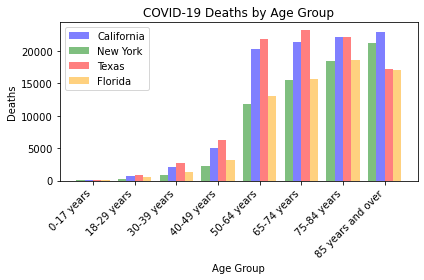

In [8]:
# Create lists for plotting
age_range = []
cali_ct = age_df[age_df["state"] == 'California']["covid_19_deaths"].tolist()
tex_ct = age_df[age_df["state"] == 'Texas']["covid_19_deaths"].tolist()
ny_ct = age_df[age_df["state"] == 'New York']["covid_19_deaths"].tolist()
flor_ct = age_df[age_df["state"] == 'Florida']["covid_19_deaths"].tolist()

for age in age_df['age_group']:
    if age in age_range:
        pass
    else:
        age_range.append(age)
        
# Set index length and bar width 
index = np.arange(8)
bar_width = 0.20
        
# Plot COVID-19 death counts by State grouped by Age Group
fig, ax = plt.subplots()
cali = ax.bar(index, cali_ct, bar_width, label="California", color="blue", alpha=0.5)
ny = ax.bar(index-bar_width, ny_ct, bar_width, label="New York", color="green", alpha=0.5)
texas = ax.bar(index+bar_width, tex_ct, bar_width, label="Texas", color="red", alpha=0.5)
florida = ax.bar(index+bar_width+bar_width, flor_ct, bar_width, label="Florida", color="orange", alpha=0.5)

# Assign title, labels, and legend
ax.set_xlabel('Age Group')
ax.set_ylabel('Deaths')
ax.set_title('COVID-19 Deaths by Age Group')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(age_range, rotation=45, ha="right")
ax.legend()

# Display the chart, and export for later use
plt.tight_layout()
plt.savefig("Images/deathct_by_agegrp.png")
plt.show()

In [9]:
# Use open client to obtain data
results2 = client.get("ks3g-spdg", limit=4000000)

# Convert to pandas DataFrame
results2_df = pd.DataFrame.from_records(results2)
results2_df

,data_as_of,start_week,end_week,state,age_group_new,race_and_hispanic_origin,covid_19_deaths,total_deaths,pneumonia_deaths,pneumonia_and_covid_19_deaths,influenza_deaths,pneumonia_influenza_or_covid_19,footnote
0,2022-04-20T00:00:00.000,2020-01-01T00:00:00.000,2022-04-16T00:00:00.000,United States,All Ages,Total Deaths,991385,7771284,876042,513106,10993,1363691,NaN
1,2022-04-20T00:00:00.000,2020-01-01T00:00:00.000,2022-04-16T00:00:00.000,United States,All Ages,Non-Hispanic White,639125,5721706,591073,319709,7552,917377,NaN
2,2022-04-20T00:00:00.000,2020-01-01T00:00:00.000,2022-04-16T00:00:00.000,United States,Under 1 year,Non-Hispanic White,98,17372,203,10,14,304,NaN
3,2022-04-20T00:00:00.000,2020-01-01T00:00:00.000,2022-04-16T00:00:00.000,United States,0-17 years,Non-Hispanic White,364,32267,642,101,103,1005,NaN
4,2022-04-20T00:00:00.000,2020-01-01T00:00:00.000,2022-04-16T00:00:00.000,United States,1-4 years,Non-Hispanic White,44,3461,128,13,31,190,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6484,2022-04-20T00:00:00.000,2020-01-01T00:00:00.000,2022-04-16T00:00:00.000,Puerto Rico,50-64 years,Unknown,NaN,30,NaN,NaN,0,NaN,One or more data cells have counts between 1-9...
6485,2022-04-20T00:00:00.000,2020-01-01T00:00:00.000,2022-04-16T00:00:00.000,Puerto Rico,55-64 years,Unknown,NaN,25,NaN,NaN,0,NaN,One or more data cells have counts between 1-9...
6486,2022-04-20T00:00:00.000,2020-01-01T00:00:00.000,2022-04-16T00:00:00.000,Puerto Rico,65-74 years,Unknown,0,20,NaN,0,0,NaN,One or more data cells have counts between 1-9...
6487,2022-04-20T00:00:00.000,2020-01-01T00:00:00.000,2022-04-16T00:00:00.000,Puerto Rico,75-84 years,Unknown,NaN,16,NaN,NaN,0,NaN,One or more data cells have counts between 1-9...


In [10]:
# Filter CDC data for the three states with highest COVID-19 deaths, to include
# death data for all race groups excepting nominal "Unknown" figures
results_race = results2_df.loc[((results2_df['state'] == 'New York City') | (results2_df['state'] == 'New York') |(results2_df['state'] == 'Texas') | (results2_df['state'] == 'California') | (results2_df['state'] == 'Florida')) & (results2_df['race_and_hispanic_origin'] != 'Total Deaths') & (results2_df['race_and_hispanic_origin'] != 'Unknown')]
results_race = results_race.loc[(results_race['age_group_new'] == '0-17 years') | (results_race['age_group_new'] == '18-29 years') | (results_race['age_group_new'] == '30-39 years') | (results_race['age_group_new'] == '40-49 years') | (results_race['age_group_new'] == '50-64 years') | (results_race['age_group_new'] == '65-74 years') | (results_race['age_group_new'] == '75-84 years') | (results_race['age_group_new'] == '85 years and over')]
results_race2 = results_race.fillna(0)
results_race2 = results_race2[['state', 'race_and_hispanic_origin', 'covid_19_deaths']]

results_race2['state'] = results_race2['state'].replace(['New York City'],'New York')

# Create copy of DataFrame for tabulation, convert death total to integer for summation
converted_race_df = results_race2.copy()
converted_race_df = converted_race_df.astype({"covid_19_deaths": "int64"})
converted_race_df

# Group DataFrame by State, Race cagtegories
group_race_df = converted_race_df.groupby(['state','race_and_hispanic_origin']).agg({'covid_19_deaths': 'sum'})
race_df = pd.DataFrame(group_race_df["covid_19_deaths"])

# Convert DataFrame to pivot table
dfr = race_df.pivot_table(index='race_and_hispanic_origin', columns='state', values='covid_19_deaths').sort_values('Texas',ascending=False)
dfr



state,California,Florida,New York,Texas
race_and_hispanic_origin,,,,
Non-Hispanic White,32281,39006,36260,41113
Hispanic,37090,14299,12328,33410
Non-Hispanic Black,5912,10475,12835,8887
Non-Hispanic Asian,10072,897,4602,1635
Non-Hispanic American Indian or Alaska Native,533,103,99,170
Non-Hispanic More than one race,619,209,114,103
Non-Hispanic Native Hawaiian or Other Pacific Islander,526,22,0,60


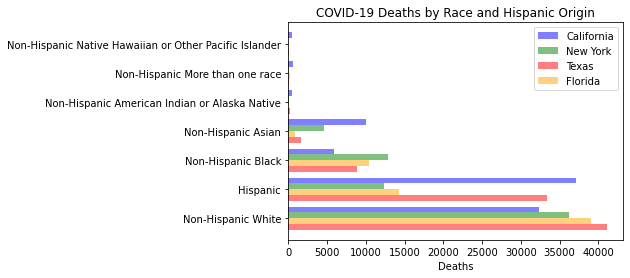

<Figure size 2160x720 with 0 Axes>

In [11]:
# Create lists for plotting
race_range = dfr.index.tolist()
cali_ct2 = dfr["California"].tolist()
ny_ct2 = dfr["New York"].tolist()
tex_ct2 = dfr["Texas"].tolist()
flor_ct2 = dfr["Florida"].tolist()

# Set index length and bar width 
index = np.arange(7)
bar_width = 0.2
        
# Plot COVID-19 death counts for each State by Race 
fig, ax = plt.subplots()
cali2 = ax.barh(index+bar_width+bar_width, cali_ct2, bar_width, label="California", color="blue", alpha=0.5)
ny2 = ax.barh(index+bar_width, ny_ct2, bar_width, label="New York", color="green", alpha=0.5)
texas2 = ax.barh(index-bar_width, tex_ct2, bar_width, label="Texas", color="red", alpha=0.5)
florida2 = ax.barh(index, flor_ct2, bar_width, label="Florida", color="orange", alpha=0.5)

# Assign title, labels, and legend
ax.set_xlabel('Deaths')
ax.set_title('COVID-19 Deaths by Race and Hispanic Origin')
ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(race_range)
ax.legend(loc="upper right")

# Display the chart, and export for later use
plt.savefig("Images/deathct_by_racegrp.png", bbox_inches='tight')
plt.figure(figsize=(30,10))
plt.tight_layout()
plt.show()

In [12]:
# from config import api_key
from config import api_key

census_2020_url = "https://api.census.gov/data/2020/dec/pl?get=NAME,P2_005N,P2_002N,P2_006N,P2_008N,P2_007N,P2_011N,P2_009N&for=state:06,12,36,48&key=" + api_key

census_data = requests.get(census_2020_url).json()

In [13]:
census_pd = pd.DataFrame(census_data).T
new_header = census_pd.iloc[0]
census_pd = census_pd[1:8]
census_pd.columns = new_header 

cali_data = census_pd['California'].astype(int).tolist()
ny_data = census_pd['New York'].astype(int).tolist()
flor_data = census_pd['Florida'].astype(int).tolist()
tex_data = census_pd['Texas'].astype(int).tolist()

dfr['California Total Pop.'] = cali_data
dfr['New York Total Pop.'] = ny_data
dfr['Florida Total Pop.'] = flor_data
dfr['Texas Total Pop.'] = tex_data

sum_cali_deaths = sum(dfr['California'])
sum_ny_deaths = sum(dfr['New York'])
sum_flor_deaths = sum(dfr['Florida'])
sum_tex_deaths = sum(dfr['Texas'])

sum_cali = sum(dfr['California Total Pop.'])
sum_ny = sum(dfr['New York Total Pop.'])
sum_flor = sum(dfr['Florida Total Pop.'])
sum_tex = sum(dfr['Texas Total Pop.'])

death_rates = pd.DataFrame({
    "State" : ["California", "Florida", "New York", "Texas"],
    "Population" : [sum_cali, sum_flor, sum_ny, sum_tex],
    "COVID-19 Deaths" : [sum_cali_deaths, sum_flor_deaths, sum_ny_deaths, sum_tex_deaths],
    "Death Rate %" : [sum_cali_deaths / sum_cali * 100,
                      sum_flor_deaths / sum_flor * 100,
                      sum_ny_deaths / sum_ny * 100,
                      sum_tex_deaths / sum_tex * 100,],
})

death_rates["Population"] = death_rates["Population"].map("{:,.0f}".format)
death_rates["COVID-19 Deaths"] = death_rates["COVID-19 Deaths"].map("{:,.0f}".format)
death_rates["Death Rate %"] = death_rates["Death Rate %"].map("{:.2f}%".format)
death_rates

,State,Population,COVID-19 Deaths,Death Rate %
0,California,"39,314,294","87,033",0.22%
1,Florida,"21,400,254","65,011",0.30%
2,New York,"20,004,142","66,238",0.33%
3,Texas,"29,031,921","85,378",0.29%


In [14]:
dfr

state,California,Florida,New York,Texas,California Total Pop.,New York Total Pop.,Florida Total Pop.,Texas Total Pop.
race_and_hispanic_origin,,,,,,,,
Non-Hispanic White,32281,39006,36260,41113,13714587,10598907,11100503,11584597
Hispanic,37090,14299,12328,33410,15579652,3948032,5697240,11441717
Non-Hispanic Black,5912,10475,12835,8887,2119286,2759022,3127052,3444712
Non-Hispanic Asian,10072,897,4602,1635,5978795,1916329,629626,1561518
Non-Hispanic American Indian or Alaska Native,533,103,99,170,156085,54908,42169,85425
Non-Hispanic More than one race,619,209,114,103,1627722,720847,792143,886095
Non-Hispanic Native Hawaiian or Other Pacific Islander,526,22,0,60,138167,6097,11521,27857


In [15]:
dfr["CA Deaths %"] = dfr['California']/sum_cali_deaths*100
dfr["CA Population %"] = dfr['California Total Pop.']/sum_cali*100

dfr["FL Deaths %"] = dfr['Florida']/sum_flor_deaths*100
dfr["FL Population %"] = dfr['Florida Total Pop.']/sum_flor*100

dfr["NY Deaths %"] = dfr['New York']/sum_ny_deaths*100
dfr["NY Population %"] = dfr['New York Total Pop.']/sum_ny*100

dfr["TX Deaths %"] = dfr['Texas']/sum_tex_deaths*100
dfr["TX Population %"] = dfr['Texas Total Pop.']/sum_tex*100

dfr[["CA Deaths %", "CA Population %", "FL Deaths %", "FL Population %", "NY Deaths %", "NY Population %", "TX Deaths %", "TX Population %"]]

state,CA Deaths %,CA Population %,FL Deaths %,FL Population %,NY Deaths %,NY Population %,TX Deaths %,TX Population %
race_and_hispanic_origin,,,,,,,,
Non-Hispanic White,37.090529,34.884480,59.999077,51.870894,54.741991,52.983562,48.154091,39.902964
Hispanic,42.616019,39.628467,21.994739,26.622301,18.611673,19.736073,39.131861,39.410816
Non-Hispanic Black,6.792826,5.390625,16.112658,14.612219,19.377095,13.792254,10.409005,11.865257
Non-Hispanic Asian,11.572622,15.207688,1.379767,2.942143,6.947674,9.579661,1.915013,5.378624
Non-Hispanic American Indian or Alaska Native,0.612411,0.397018,0.158435,0.197049,0.149461,0.274483,0.199115,0.294245
Non-Hispanic More than one race,0.711224,4.140280,0.321484,3.701559,0.172107,3.603489,0.120640,3.052140
Non-Hispanic Native Hawaiian or Other Pacific Islander,0.604368,0.351442,0.033840,0.053836,0.000000,0.030479,0.070276,0.095953


In [16]:
# The degree of freedom is 7-1 = 6 
# With a p-value of 0.05, the confidence level is 1.00-0.05 = 0.95.
critical_value = stats.chi2.ppf(q = 0.95, df = 6)

In [17]:
# The critical value
critical_value

12.591587243743977

In [18]:
stats.chisquare(dfr['CA Deaths %'], dfr['CA Population %'])

Power_divergenceResult(statistic=4.737247309039826, pvalue=0.5779273722180895)

In [19]:
stats.chisquare(dfr['FL Deaths %'], dfr['FL Population %'])

Power_divergenceResult(statistic=6.163314362718218, pvalue=0.40514656273731947)

In [20]:
stats.chisquare(dfr['NY Deaths %'], dfr['NY Population %'])

Power_divergenceResult(statistic=6.461916429225132, pvalue=0.3734802431939379)

In [21]:
stats.chisquare(dfr['TX Deaths %'], dfr['TX Population %'])

Power_divergenceResult(statistic=6.970548766065622, pvalue=0.32357943018838314)